<a href="https://colab.research.google.com/github/pandu1992/SimulationPricing/blob/main/Research_PPB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

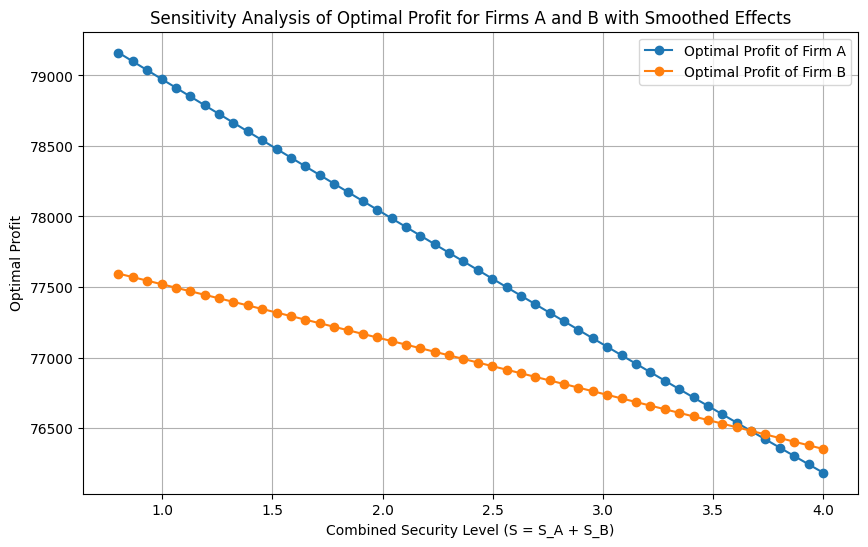

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Generate Synthetic Data with Adjusted Parameters
n = 1000  # Number of observations

# Generate synthetic data using normal distribution with adjusted parameters
L_A = np.random.normal(loc=5000, scale=800, size=n)  # Lines of reused code (Firm A)
L_B = np.random.normal(loc=6000, scale=1200, size=n)  # Lines of new code (Firm B)
delta = np.random.normal(loc=0.15, scale=0.03, size=n)  # Efficiency gains (Firm A)
e = 0.005  # Energy per line of code (constant for simplicity)
C_A = np.random.normal(loc=8000, scale=1500, size=n)  # Costs for Firm A
C_B = np.random.normal(loc=10000, scale=2000, size=n)  # Costs for Firm B

# Security and Performance Levels with increased variance
S_A = np.random.uniform(0.4, 1.2, size=n)  # Security level for Firm A
S_B = np.random.uniform(0.4, 1.2, size=n)  # Security level for Firm B
P_A = np.random.uniform(0.6, 0.95, size=n)  # Performance of reused code
P_B = np.random.uniform(0.75, 1.05, size=n)  # Optimized performance from scratch development

# Calculate energy consumption based on synthetic data with adjusted parameters
E_A = e * L_A * (1 - delta)  # Energy consumption for Firm A
E_B = e * L_B  # Energy consumption for Firm B

# Combine data into a DataFrame
data = pd.DataFrame({
    'L_A': L_A,
    'L_B': L_B,
    'delta': delta,
    'C_A': C_A,
    'C_B': C_B,
    'E_A': E_A,
    'E_B': E_B,
    'S_A': S_A,
    'S_B': S_B,
    'P_A': P_A,
    'P_B': P_B
})

# Step 2: Feature Selection and Training the Model
# Including more relevant features
X = data[['L_A', 'L_B', 'delta', 'S_A', 'P_A']]
y_A = data['E_A']
y_B = data['E_B']

# Split the data into training and test sets
X_train, X_test, y_A_train, y_A_test = train_test_split(X, y_A, test_size=0.2, random_state=42)
_, _, y_B_train, y_B_test = train_test_split(X, y_B, test_size=0.2, random_state=42)

# Train Random Forest models with adjusted parameters for predicting energy consumption
rf_model_A = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model_B = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

rf_model_A.fit(X_train, y_A_train)
rf_model_B.fit(X_train, y_B_train)

# Predict energy consumption for all data
data['E_A_pred'] = rf_model_A.predict(data[['L_A', 'L_B', 'delta', 'S_A', 'P_A']])
data['E_B_pred'] = rf_model_B.predict(data[['L_A', 'L_B', 'delta', 'S_A', 'P_A']])

# Step 3: Conduct Sensitivity Analysis using Extended Range of Combined Parameter S = S_A + S_B
# Define constants for analysis
alpha = 0.3  # Cost of energy consumption for Firm A
beta = 0.3   # Cost of energy consumption for Firm B
a = 900      # Base demand level
gamma = 0.4  # Cross-elasticity of demand
lambda_S_A = 1.5  # Higher importance of security to demand for Firm A
lambda_S_B = 0.5  # Lower importance of security to demand for Firm B
lambda_P = 0.4  # Importance of performance to demand
mu_S_A = 2000  # Cost impact of security for Firm A
mu_S_B = 800   # Cost impact of security for Firm B
mu_P = 800     # Cost impact of performance
b = 0.15       # Sensitivity of demand to price

# Extend the range of combined security levels for analysis
combined_security_values = np.linspace(0.8, 4.0, 50)  # Extended range of S_A + S_B

# Initialize lists to store results for combined sensitivity analysis
profit_A_list = []
profit_B_list = []

# Sensitivity Analysis using combined parameter S = S_A + S_B
for S_combined in combined_security_values:
    S_A_level = S_combined / 2
    S_B_level = S_combined / 2

    # Fixed prices for comparison
    p_A = 100
    p_B = 100

    # Smoothed non-linear effects using more gradual functions
    S_A_effect = lambda_S_A * (np.exp(S_A_level / 2) - 1)  # Smoother exponential effect for Firm A
    S_B_effect = lambda_S_B * np.log(S_B_level + 1)  # Logarithmic effect for Firm B, remains

    # Calculate demand for both firms
    D_A = a - b * p_A + gamma * (p_B - p_A) + S_A_effect + lambda_P * np.mean(data['P_A'])
    D_B = a - b * p_B + gamma * (p_A - p_B) + S_B_effect + lambda_P * np.mean(data['P_B'])
    D_A = max(D_A, 0)
    D_B = max(D_B, 0)

    # Calculate profit for both firms with differentiated cost impact
    P_A = (p_A * D_A) - np.mean(data['C_A']) - alpha * np.mean(data['E_A_pred']) - mu_S_A * S_A_level - mu_P * np.mean(data['P_A'])
    P_B = (p_B * D_B) - np.mean(data['C_B']) - beta * np.mean(data['E_B_pred']) - mu_S_B * S_B_level - mu_P * np.mean(data['P_B'])
    U_A = P_A - alpha * np.mean(data['E_A_pred'])
    U_B = P_B - beta * np.mean(data['E_B_pred'])

    # Store the results
    profit_A_list.append(U_A)
    profit_B_list.append(U_B)

# Step 4: Visualization of Combined Sensitivity Analysis for Profits
plt.figure(figsize=(10, 6))
plt.plot(combined_security_values, profit_A_list, label='Optimal Profit of Firm A', marker='o')
plt.plot(combined_security_values, profit_B_list, label='Optimal Profit of Firm B', marker='o')
plt.xlabel('Combined Security Level (S = S_A + S_B)')
plt.ylabel('Optimal Profit')
plt.title('Sensitivity Analysis of Optimal Profit for Firms A and B with Smoothed Effects')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import pandas as pd

# Number of observations
n = 1000

# Generate data using normal distribution
np.random.seed(42)  # For reproducibility

# Lines of reused code (Firm A)
L_A = np.random.normal(loc=5000, scale=1000, size=n)

# Lines of new code (Firm B)
L_B = np.random.normal(loc=6000, scale=1500, size=n)

# Efficiency gains (Firm A)
delta = np.random.normal(loc=0.2, scale=0.05, size=n)

# Energy per line of code (constant)
e = 0.005  # kWh per line

# Costs for Firms A and B
C_A = np.random.normal(loc=10000, scale=2000, size=n)  # in monetary units
C_B = np.random.normal(loc=12000, scale=2500, size=n)

# Combine data into a DataFrame
data = pd.DataFrame({
    'L_A': L_A,
    'L_B': L_B,
    'delta': delta,
    'C_A': C_A,
    'C_B': C_B
})

# Display the first few rows of the generated data
print(data.head())


           L_A          L_B     delta           C_A           C_B
0  5496.714153  8099.033155  0.166241   6184.384884   9841.265988
1  4861.735699  7386.950524  0.192774   8279.229978  11921.991278
2  5647.688538  6089.445555  0.160379   9172.788933  12045.042180
3  6523.029856  5029.594833  0.184602  13775.375315  13181.575865
4  4765.846625  7047.334970  0.105319  11113.106249   8582.854092


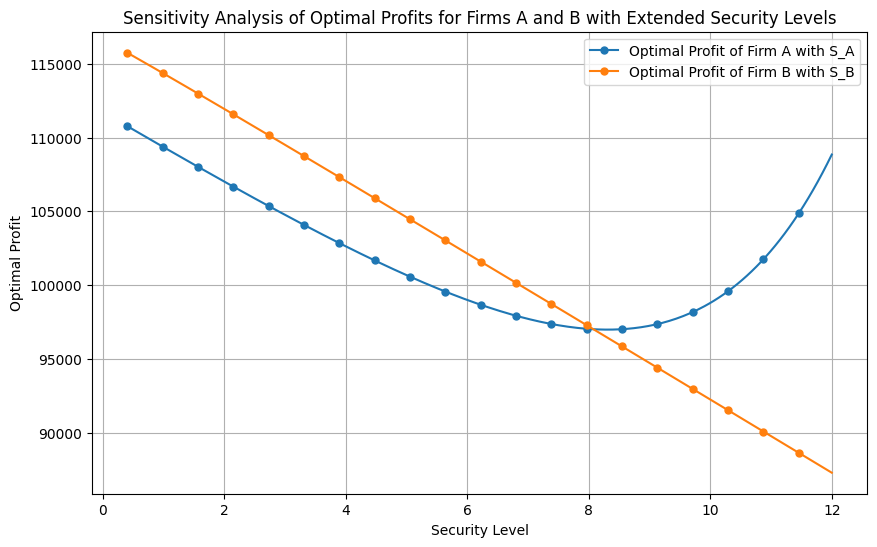

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Generate Synthetic Data with Adjusted Parameters
n = 1000  # Number of observations

# Generate synthetic data using normal distribution with adjusted parameters
L_A = np.random.normal(loc=5000, scale=800, size=n)  # Lines of reused code (Firm A)
L_B = np.random.normal(loc=6000, scale=1200, size=n)  # Lines of new code (Firm B)
delta = np.random.normal(loc=0.15, scale=0.03, size=n)  # Efficiency gains (Firm A)
e = 0.005  # Energy per line of code (constant for simplicity)
C_A = np.random.normal(loc=8000, scale=1500, size=n)  # Costs for Firm A
C_B = np.random.normal(loc=10000, scale=2000, size=n)  # Costs for Firm B

# Security and Performance Levels with increased variance
S_A = np.random.uniform(0.4, 1.2, size=n)  # Security level for Firm A
S_B = np.random.uniform(0.4, 1.2, size=n)  # Security level for Firm B
P_A = np.random.uniform(0.6, 0.95, size=n)  # Performance of reused code
P_B = np.random.uniform(0.75, 1.05, size=n)  # Optimized performance from scratch development

# Calculate energy consumption based on synthetic data with adjusted parameters
E_A = e * L_A * (1 - delta)  # Energy consumption for Firm A
E_B = e * L_B  # Energy consumption for Firm B

# Combine data into a DataFrame
data = pd.DataFrame({
    'L_A': L_A,
    'L_B': L_B,
    'delta': delta,
    'C_A': C_A,
    'C_B': C_B,
    'E_A': E_A,
    'E_B': E_B,
    'S_A': S_A,
    'S_B': S_B,
    'P_A': P_A,
    'P_B': P_B
})

# Step 2: Feature Selection and Training the Model
# Including more relevant features
X = data[['L_A', 'L_B', 'delta', 'S_A', 'P_A']]
y_A = data['E_A']
y_B = data['E_B']

# Split the data into training and test sets
X_train, X_test, y_A_train, y_A_test = train_test_split(X, y_A, test_size=0.2, random_state=42)
_, _, y_B_train, y_B_test = train_test_split(X, y_B, test_size=0.2, random_state=42)

# Train Random Forest models with adjusted parameters for predicting energy consumption
rf_model_A = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model_B = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

rf_model_A.fit(X_train, y_A_train)
rf_model_B.fit(X_train, y_B_train)

# Predict energy consumption for all data
data['E_A_pred'] = rf_model_A.predict(data[['L_A', 'L_B', 'delta', 'S_A', 'P_A']])
data['E_B_pred'] = rf_model_B.predict(data[['L_A', 'L_B', 'delta', 'S_A', 'P_A']])

# Step 3: Conduct Sensitivity Analysis Separately for S_A and S_B
# Define constants for analysis with more differentiation
alpha = 0.3  # Cost of energy consumption for Firm A
beta = 0.3  # Aligned cost for Firm B to match Firm A more closely
a_A = 900    # Base demand level for Firm A
a_B = 900    # Matching base demand level for Firm B
gamma_A = 0.5  # Cross-elasticity of demand for Firm A
gamma_B = 0.5  # Matching cross-elasticity for Firm B
lambda_S_A = 1.5  # Importance of security to demand for Firm A
lambda_S_B = 1.5  # Matching importance of security to demand for Firm B
lambda_P = 0.4  # Importance of performance to demand
mu_S_A = 2500  # Matching cost impact of security for both firms
mu_S_B = 2500  # Matching cost impact of security for both firms
mu_P = 1000    # Moderate cost impact of performance
b_A = 0.15     # Increased sensitivity of demand to price for Firm A
b_B = 0.15     # Increased sensitivity of demand to price for Firm B

# Extend the range of security levels for Firm A and Firm B
security_values_A = np.linspace(0.4, 12.0, 300)  # Extended security level range for Firm A
security_values_B = np.linspace(0.4, 12.0, 300)  # Extended security level range for Firm B

# Initialize lists to store results for sensitivity analysis
optimal_profit_A_list = []
optimal_profit_B_list = []

# Sensitivity Analysis for Firm A with respect to S_A
for S_A_level in security_values_A:
    # Optimization to find optimal profit for each security level
    best_profit_A = -np.inf

    # Define a range of prices to optimize over
    price_range_A = np.linspace(40, 150, 50)

    for p_A in price_range_A:
        # Calculate demand for Firm A
        S_A_effect = lambda_S_A * (np.exp(S_A_level / 2.5) - 1)  # Adjusted exponential effect for Firm A
        D_A = a_A - b_A * p_A + gamma_A * (np.mean(data['P_B']) - p_A) + S_A_effect + lambda_P * np.mean(data['P_A'])
        D_A = max(D_A, 0)

        # Calculate profit for Firm A
        P_A = (p_A * D_A) - np.mean(data['C_A']) - alpha * np.mean(data['E_A_pred']) - mu_S_A * S_A_level - mu_P * np.mean(data['P_A'])

        # Check if current price gives a higher profit
        if P_A > best_profit_A:
            best_profit_A = P_A

    # Store the optimal profit for each security level
    optimal_profit_A_list.append(best_profit_A)

# Sensitivity Analysis for Firm B with respect to S_B
for S_B_level in security_values_B:
    # Optimization to find optimal profit for each security level
    best_profit_B = -np.inf

    # Define a range of prices to optimize over
    price_range_B = np.linspace(50, 160, 50)

    for p_B in price_range_B:
        # Calculate demand for Firm B
        S_B_effect = lambda_S_B * np.log(S_B_level + 1)  # Adjusted logarithmic effect for Firm B
        D_B = a_B - b_B * p_B + gamma_B * (np.mean(data['P_A']) - p_B) + S_B_effect + lambda_P * np.mean(data['P_B'])
        D_B = max(D_B, 0)

        # Calculate profit for Firm B
        P_B = (p_B * D_B) - np.mean(data['C_B']) - beta * np.mean(data['E_B_pred']) - mu_S_B * S_B_level - mu_P * np.mean(data['P_B'])

        # Check if current price gives a higher profit
        if P_B > best_profit_B:
            best_profit_B = P_B

    # Store the optimal profit for each security level
    optimal_profit_B_list.append(best_profit_B)

# Step 4: Visualization of Sensitivity Analysis for Profits with Extended Security Levels
plt.figure(figsize=(10, 6))
plt.plot(security_values_A, optimal_profit_A_list, label='Optimal Profit of Firm A with S_A', linestyle='-', marker='o', markersize=5, markevery=15)
plt.plot(security_values_B, optimal_profit_B_list, label='Optimal Profit of Firm B with S_B', linestyle='-', marker='o', markersize=5, markevery=15)
plt.xlabel('Security Level')
plt.ylabel('Optimal Profit')
plt.title('Sensitivity Analysis of Optimal Profits for Firms A and B with Extended Security Levels')
plt.legend()
plt.grid(True)
plt.show()
